**SI6160 Homework 1 Perceptron Implementation**<br>
<br>
**John Olijnyk & John Machado**<br>
**1/31/2022**<br>
<br>
We will implment a perceptron algorithm and use it to draw a decision boundary in linearly seperable data.<br>
<br>
References:<br>
-  https://towardsdatascience.com/perceptron-algorithm-in-python-f3ac89d2e537<br>

In [1]:
# imports

from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

We begin by generating data.
We created a function that generates a user specified number of data points each clustered around one of two centroids.
The deviation in each cluster is random from execution to execution.
Each data point has two features and a label; the label corresponds to the cluster to which the data point belongs.

In [2]:
def generate_data(number_of_rows):
    
    """
        generates a DataFrame of with columns x, y, and label and number of rows equal to number_of_rows.
        data generated with make_blobs from numpy.datasets

        Parameters:
            number_of_rows (int): the number of rows to b generated

        Returns:
            (DataFrame): columns - x, y, and label; rows - number_of_rows
    """
    
    # initialize the random number generator
    random.seed()

    # make_blobs for point generation
    points, labels = datasets.make_blobs(
            n_samples = number_of_rows,
            n_features = 2,
            centers = 2,
            cluster_std = 1.25,  #standard deviation.  can control linear separation. large value will cause overlap
            random_state = random.randint(1,100))

    # put data into dataframe
    _dict = {
        'x': points[:,0],
        'y': points[:,1],
        'label': labels
    }
    df = pd.DataFrame().from_dict(_dict)
    
    # return
    return df

In [3]:
# generate and print the first 5 rows of random clustered data
# we generate 100 data points with a standard deviation of 1.25 to keep linear separation
clusters_df = generate_data(100)
clusters_df.head()

,x,y,label
0,3.004536,-6.783986,1
1,3.451657,-2.859966,0
2,2.388872,-6.272167,1
3,2.775025,-6.857458,1
4,2.640108,-6.964943,1


Next, we created a function to display a scatter plot of our data. We will use this function later to draw the decision boundary.

In [4]:
def plot_df(df, padding=0.2):

    """
        plots the dataframe generated in generate_data() with color coded clusters

        Parameters:
            df (DataFrame): DataFrame to be plotted. Should be generated with generate_data(). Columns must be [feature, feature, label].
            padding (float, optional, default=0.2): Percent of total width of data set to pad each axis.

        Returns:
            (None)
    """

    # set plot size
    plt.figure(figsize=(10,10))

    # scatter plot of the label = 0
    plt.scatter(
        df[df.iloc[:,2] == 0].iloc[:,0],  # all rows in column 'x' where 'label' is zero
        df[df.iloc[:,2] == 0].iloc[:,1],  # all rows in column 'y' where 'label' is zero 
        edgecolors='white',  
        marker='o',
        color='g', 
        s=60,
        label='0'
    )

    # scatter plot of label 1
    plt.scatter(
        df[df.iloc[:,2] == 1].iloc[:,0],  # all rows in column 'x' where 'label' is one
        df[df.iloc[:,2] == 1].iloc[:,1],  # all rows in column 'y' where 'label' is one 
        edgecolors='white', 
        marker='s',
        color='b',
        s=60,
        label='1'
    )

    # plot x axis label
    plt.xlabel(df.columns[0])
    # plot y axis label
    plt.ylabel(df.columns[1])
    # plot legend
    plt.legend()

    # pad x axis 
    plt.xlim(pad_range(padding, {'max': df.iloc[:,0].max(), 'min': df.iloc[:,0].min()}))
    
    # pad y axis
    plt.ylim(pad_range(padding, {'max': df.iloc[:,1].max(), 'min': df.iloc[:,1].min()}))
    
    # get average deviations for plot title
    deviations= []
    for i in range(4):
        p_label = math.floor(i/2)
        p_feature = i % 2
        deviations.append(clusters_df[clusters_df.iloc[:,2] == p_label].iloc[:,p_feature].std())
    average = sum(deviations)/len(deviations)
    
    # plot title
    plt.title(f'avera cluster deviation: {average:.2f}')


def pad_range(pad_width, _range):

    """
        padds a range with +- pad_width. 
        used to set pyplot.xlim() and pyplot.ylim() axis ranges.

        Parameters:
            pad_width (float): percent of the range to add to each side of the plot
            _range (dictionary): max and min of the range
        
        Returns:
            (list): [_min - _pad, _max + _pad]
    """

    # left pad = min - pad * (max - min)
    # right pad = max + pad * (max - min)
    _max = _range['max']
    _min = _range['min']
    _delta = _max - _min
    _pad = pad_width * _delta
    return [_min - _pad, _max + _pad]

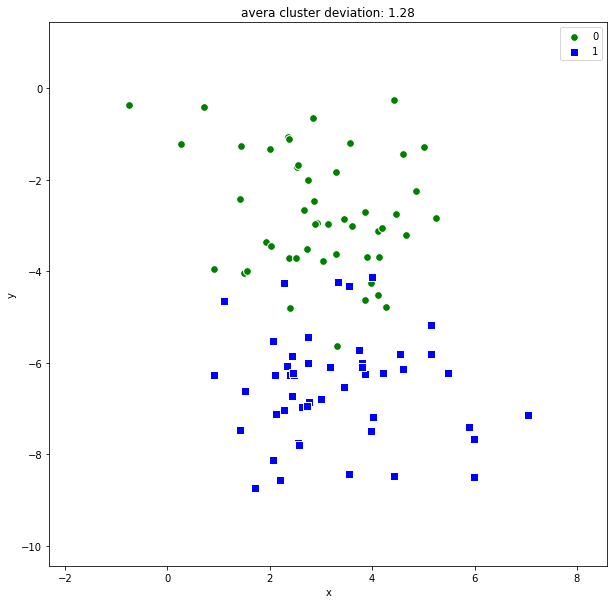

In [5]:
# plot generated data
# We note that we can see that the data set is indeed linearly separateable.


plot_df(clusters_df)

Next, we wrote our perceptron function. The function trains a theta over each data point and each epoch. Theta begins as a zero array of dimensions [feature_count+1, 0]. For each data point, the data point is processby by concatenation with a weight term, so the data point in the algorithm will be of dimensions [feature_count+1, 0]. A prediction is generated by taking the dot product of theta and the processed data point and comparing the result to a threashold value. For binary classification, the prediction is True if the value of the dot product is above the threashold and false if it is less than or equal to the threashold. If the prediction does not agree with the label, theta is updated by multiplying the learning rate, the processed data point, and the delta between the label and prediction. We kept track of the number of misclassified points in each epoch for observation. The learning rate represents how much of a change is made from one iteration i.e. epoch to another as the line position and slope is adjusted. Depending on how large of a learning rate and on how many epochs the algorithm convergence will vary as will the accuracy of the position of the line to separate the two data clusters. There may be times where the line may shift to cause prediction errors or might not have enough iterations to fully adjust to an optimal position. This tuning is critical for a perceptron to have a good balance of learning rate and epochs.

In [6]:
def perceptron(data, epochs=10, learning_rate=0.1):
    
    """
        perceptron training algorithm.
        calls activation_function() for neuron activation.

        Parameters:
            data (DataFrame): data to train the perceptron on. Needs to be in the format [feature, feature, label]
            epochs (int, optional, default=10): number of training cycles
            learning_rate (float, optional, default=0.1): determines the magnitude of the offset applied to theta on a failed prediction

        Returns:
            (list): trained theta. give to predict() along with a point to make a prediction.
    """

    # separate dataframe in to components
    labels = data.iloc[:,-1]
    samples = data.iloc[:,:-1]

    # get some important dimensions
    sample_count = samples.shape[0]
    feature_count  = samples.shape[1]

    # initialize theta
    theta = np.zeros((feature_count + 1, 1))

    # initialize list for keeping track of misclassified points
    misclassified_counts = [0 for _ in range(epochs)]

    # set training values
    threashold = 0.0
    active = 1.0
    inactive = 0.0

    # repeat training on entire data set epochs number of times
    for e in range(epochs):

        # repeat training for each point in data set
        for i, sample_i in enumerate(samples.iterrows()):

            # process the sample from the data set
            sample_i = np.array([sample_i[1][0], sample_i[1][1]])
            sample_i = np.insert(sample_i, 0, 1).reshape(-1, 1)

            # get the dot product for prediction
            dot = np.squeeze(np.dot(sample_i.T, theta))

            # make prediction
            prediction = inactive
            if dot > threashold: prediction = active

            # train if the prediction does not agree with the label
            if prediction - labels[i] == 0: continue 
            theta += learning_rate * sample_i * (labels[i] - prediction)
            
            # keep track of incorrect predictions for each epoch
            misclassified_counts[e] += 1
            
    # return
    return theta, misclassified_counts

In [7]:
# observe misclassified points per epoch 
# and observe how quickly the algorithm converges to zero or minimal misclassifications.

theta, counts = perceptron(clusters_df)

In [8]:
# observe theta vector

_theta_df = pd.DataFrame(theta, columns=['final_theta'])
_theta_df

,final_theta
0,-4.200000
1,0.232052
2,-1.562830


In [9]:
# observe misclassified points per epoch

_misclassifications_df = pd.DataFrame().from_dict({'epoch':[x for x in range(len(counts))], 'misclassifications': counts})
_misclassifications_df

,epoch,misclassifications
0,0,33
1,1,29
2,2,26
3,3,23
4,4,21
5,5,21
6,6,23
7,7,16
8,8,17
9,9,15


Finally, we plot the decision boundary.
The decision boundary is a line whose slope is given by -theta[1]/theta[2] and whose intercept is given by -theta[0]/theta[2]. 


In [10]:
def plot_decision_boundary(data, theta, padding=0.2):
    
    """
        scatterplot of data with decision boundary

        Parameters:
            data (DataFrame): dataset perceptron was trained on.
                needs to be in the form [feature, feature, label]
            theta (list): resultant theta from perceptron training
            padding (float, optional, default=0.2): percent of the range of the data to padd each axis.
        Returns:
            (None): just draws the plot
    """

    # dont run on divide by 0
    if theta[2] == 0: return

    # plot the original data
    plot_df(data, padding)

    # get line bounds for feature 1 and adjust for padding
    data_range = {
        'max': data.iloc[:,0].max(),
        'min': data.iloc[:,0].min()
    }
    feature_1_range = pad_range(padding, data_range)
    
    # get slope and intercept of line
    slope = -theta[1]/theta[2]
    intercept = -theta[0]/theta[2]

    # calculate line bounds for feature 2 based on above
    feature_2_range = slope * feature_1_range + intercept

    # plot decision boundary
    plt.plot(
        feature_1_range,
        feature_2_range,
        linewidth=2,
        color='red',
        label='decision boundary'
    )
    plt.legend()

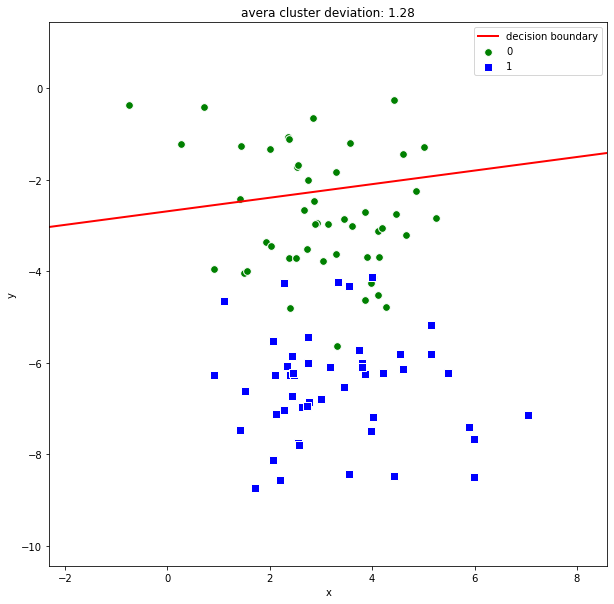

In [11]:
# plot decision boundary 
plot_decision_boundary(clusters_df, theta)

In conclusion we see how a perceptron is effective working with linearly separateable data. We noted how it used the dot product to generate a line and then uses the learning rate and each epoch to adjust that line to achieve better accuracy. As the algorithm gets extended to more dimensions, instead of a line you will get a plane or hyperplane for seperation.